# Model match outcome
Try a variety of models: Logistic regression, Random Forest, xgboost. Outstanding question: Can we see how well our scores perform vs. using Betfair Starting Price scores? We'll need to download BSP data and treat it as a source of truth. It would also be good to analyse BSP probabilities for weaknesses, are there any types of match (strong favourite? certain countries? finals vs qualifying rounds?) that BSP predicts badly? (if the model does better - we could use it to guide snooker betting tips!)

In [1]:
!pip install xgboost

### Imports and constants

In [2]:
import requests

import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


pd.options.display.max_columns = 500
plt.style.use('seaborn')

In [3]:
from snooker_matches.visualisation import calibration_plot

In [4]:
TARGET_COL = 'WIN'

NULL_IMPUTATION_VALUE = -99999

RANDOM_SEED = 12345

TRIPLE_CROWN_EVENTS = ['World Championship', 'UK Championship', 'Masters']

### Load and process data

In [5]:
players = pd.read_csv('data/Players_data.csv')
match_data = pd.read_csv('data/Raw_data.csv', low_memory=False)

In [6]:
match_data['TripleCrown'] = (match_data['Name'].isin(['World Championship', 'UK Championship', 'Masters'])).astype(int)
match_data['BestOf'] = match_data[['Score1', 'Score2']].max(axis=1)*2 - 1
match_data['CountryEqualsPlayer1Nationality'] = (match_data['Player1Nationality'] == match_data['Country']).astype(int)
match_data['CountryEqualsPlayer2Nationality'] = (match_data['Player2Nationality'] == match_data['Country']).astype(int)

In [7]:
match_data['delta_seeding'] = match_data['Player1Seeding'] - match_data['Player2Seeding']
match_data['delta_YearsAsPro'] = match_data['Player1YearsAsPro'] - match_data['Player2YearsAsPro']
match_data['delta_LastSeasonRank'] = match_data['Player1LastSeasonRank'] - match_data['Player2LastSeasonRank']
match_data['delta_LastSeasonSum'] = match_data['Player1LastSeasonSum'] - match_data['Player2LastSeasonSum']

In [8]:
FULL_FEATURE_LIST = [
    'Country',
    'Type_event',
    'NumCompetitors',
    'Stage',
    'TripleCrown',
    'BestOf',
    'Player1Nationality',
    'Player2Nationality',
    'CountryEqualsPlayer1Nationality',
    'CountryEqualsPlayer2Nationality',
    'Player1Seeding',
    'Player2Seeding',
    'Player1YearsAsPro',
    'Player2YearsAsPro',
    'Player1LastSeasonRank',
    'Player2LastSeasonRank',
    'Player1LastSeasonSum',
    'Player2LastSeasonSum',
    'delta_seeding',
    'delta_YearsAsPro',
    'delta_LastSeasonRank',
    'delta_LastSeasonSum'
]

In [9]:
PROCESSED_FEATURE_LIST = FULL_FEATURE_LIST
NUMERIC_FEATURES = []

for feature in FULL_FEATURE_LIST:
    if pd.to_numeric(match_data.loc[~match_data[feature].isnull(), feature], errors='coerce').isnull().sum() > 0:
        print('{} is not numeric! Encoding as one-hot...'.format(feature))
        match_data = pd.get_dummies(match_data, columns=[feature], prefix=feature)
        PROCESSED_FEATURE_LIST = PROCESSED_FEATURE_LIST + \
            [col for col in match_data.columns if col.startswith('{}_'.format(feature))]
        PROCESSED_FEATURE_LIST.remove(feature)
    else:
        NUMERIC_FEATURES.append(feature)
        

Country is not numeric! Encoding as one-hot...
Type_event is not numeric! Encoding as one-hot...
Stage is not numeric! Encoding as one-hot...
Player1Nationality is not numeric! Encoding as one-hot...
Player2Nationality is not numeric! Encoding as one-hot...


In [10]:
match_data[PROCESSED_FEATURE_LIST] = match_data[PROCESSED_FEATURE_LIST].fillna(NULL_IMPUTATION_VALUE)

# Try out some models

Split the data so that our metrics can be based on test set data.

In [11]:
train, test = train_test_split(match_data, train_size=0.75, random_state=RANDOM_SEED)

## 1. Logistic Regression

Note: We should scale the data, since logistic regression generally performs better on normalised datasets. We don't need to scale for the tree-based algorithms.

In [12]:
scaler = StandardScaler()

scaler.fit(train[NUMERIC_FEATURES])
train[NUMERIC_FEATURES] = scaler.transform(train[NUMERIC_FEATURES])
test[NUMERIC_FEATURES] = scaler.transform(test[NUMERIC_FEATURES])

C:\Users\ollie\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ollie\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ollie\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
lr = LogisticRegressionCV(cv=5, random_state=0)
lr.fit(train[PROCESSED_FEATURE_LIST], train[TARGET_COL])

model_df = pd.DataFrame({
    'probability_pred': lr.predict_proba(test[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': lr.predict(test[PROCESSED_FEATURE_LIST]),
    'outcome': test[TARGET_COL].values
})

In [14]:
model_df.head()

,probability_pred,outcome_pred,outcome
0,0.658094,1,0
1,0.590872,1,1
2,0.220267,0,0
3,0.345448,0,1
4,0.608830,1,1


How well calibrated are our model's probability estimates?

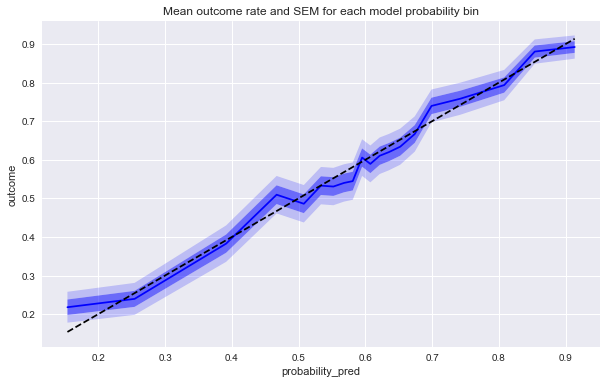

In [15]:
axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title('Mean outcome rate and SEM for each model probability bin')
plt.show()

What is our accuracy?

In [20]:
pd.DataFrame(confusion_matrix(model_df['outcome'], model_df['outcome_pred'], normalize='true')).rename(
    columns={0: 'Predicted 0', 1: 'Predicted 1'},
    index={0: 'Outcome 0', 1: 'Outcome 1'}
)

,Predicted 0,Predicted 1
Outcome 0,0.338848,0.661152
Outcome 1,0.124028,0.875972


In [21]:
print('Model accuracy score: {}'.format(accuracy_score(model_df['outcome_pred'], model_df['outcome'])))

Model accuracy score: 0.6549700739349842


## 2. Random Forest

In [22]:
train, test = train_test_split(match_data, train_size=0.75, random_state=RANDOM_SEED)

In [23]:
rf = RandomForestClassifier(
    n_estimators=75,
    max_features=20,
    max_depth=5,
    min_samples_leaf=0.001,
    random_state=RANDOM_SEED
)
rf.fit(train[PROCESSED_FEATURE_LIST], train[TARGET_COL])

model_df = pd.DataFrame({
    'probability_pred': rf.predict_proba(test[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': rf.predict(test[PROCESSED_FEATURE_LIST]),
    'outcome': test[TARGET_COL].values
})

How well calibrated are the probability estimates?

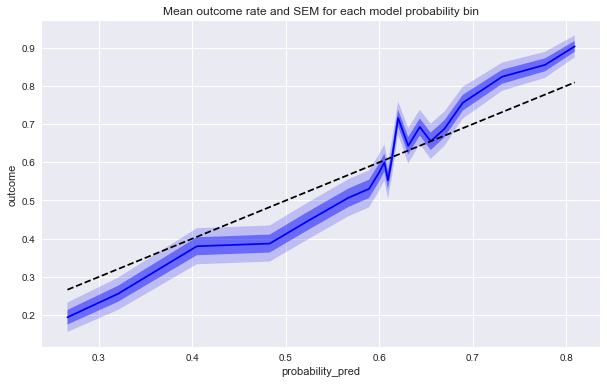

In [24]:
axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title('Mean outcome rate and SEM for each model probability bin')
plt.show()

Accuracy?

In [25]:
print('Model accuracy score: {}'.format(accuracy_score(model_df['outcome_pred'], model_df['outcome'])))

Model accuracy score: 0.6636545006454642


## 2b. Hyperparameter optimisation on Random Forest

In [26]:
from sklearn.model_selection import GridSearchCV


rf = RandomForestClassifier(
    n_jobs=-1, 
    max_features='sqrt', 
    n_estimators=75,
    max_depth=5,
    min_samples_leaf=0.001
)

param_grid = { 
    'n_estimators': [75, 100, 125, 150, 175],
    'max_depth': [5, 7, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [0.05, 0.01, 0.005, 0.001, 0.0005]
}

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
CV_rf.fit(match_data[PROCESSED_FEATURE_LIST], match_data[TARGET_COL])
print(CV_rf.best_params_)

{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 0.005, 'n_estimators': 75}


Let's use these parameters and retrain the RF.

In [27]:
rf = RandomForestClassifier(
    **CV_rf.best_params_,
    random_state=RANDOM_SEED
)
rf.fit(train[PROCESSED_FEATURE_LIST], train[TARGET_COL])

model_df = pd.DataFrame({
    'probability_pred': rf.predict_proba(test[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': rf.predict(test[PROCESSED_FEATURE_LIST]),
    'outcome': test[TARGET_COL].values
})

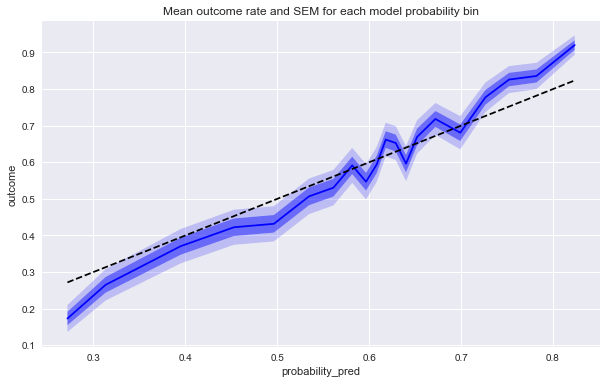

In [28]:
axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title('Mean outcome rate and SEM for each model probability bin')
plt.show()

In [29]:
pd.DataFrame(confusion_matrix(model_df['outcome'], model_df['outcome_pred'], normalize='true')).rename(
    columns={0: 'Predicted 0', 1: 'Predicted 1'},
    index={0: 'Outcome 0', 1: 'Outcome 1'}
)

,Predicted 0,Predicted 1
Outcome 0,0.374501,0.625499
Outcome 1,0.126820,0.873180


In [30]:
print('Model accuracy score: {}'.format(accuracy_score(model_df['outcome_pred'], model_df['outcome'])))

Model accuracy score: 0.6679967140007042


## 3. xgboost

In [31]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=RANDOM_SEED)
xgb_model.fit(train[PROCESSED_FEATURE_LIST], train[TARGET_COL])

model_df = pd.DataFrame({
    'probability_pred': xgb_model.predict_proba(test[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': xgb_model.predict(test[PROCESSED_FEATURE_LIST]),
    'outcome': test[TARGET_COL].values
})

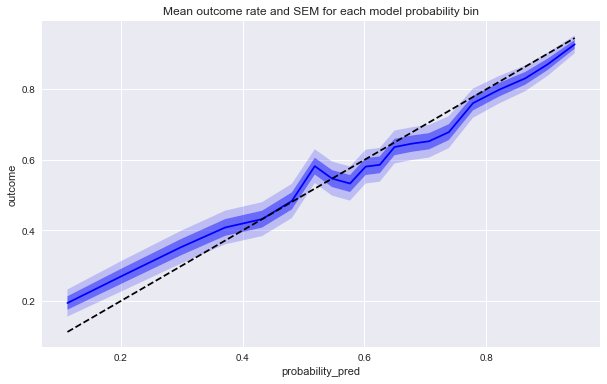

In [32]:
axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title('Mean outcome rate and SEM for each model probability bin')
plt.show()

In [33]:
print('Model accuracy score: {}'.format(accuracy_score(model_df['outcome_pred'], model_df['outcome'])))

Model accuracy score: 0.6742166412392911


### 3a. Calibration layer and XGBoost
We calibrate the output of `XGBClassifier` so that the output probabilities are more accurate. 

In [34]:
from sklearn.calibration import CalibratedClassifierCV

In [35]:
calibrated_xgb = CalibratedClassifierCV(
    base_estimator=xgb.XGBClassifier(
        objective="binary:logistic", 
        random_state=RANDOM_SEED
    ), 
    method='isotonic', 
    cv=5
)
calibrated_xgb.fit(train[PROCESSED_FEATURE_LIST], train[TARGET_COL])

model_df = pd.DataFrame({
    'probability_pred': calibrated_xgb.predict_proba(test[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': calibrated_xgb.predict(test[PROCESSED_FEATURE_LIST]),
    'outcome': test[TARGET_COL].values
})

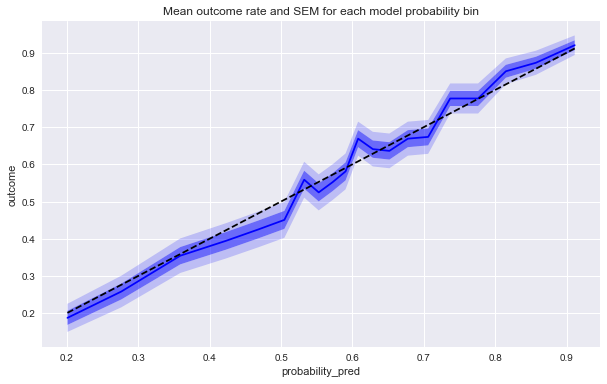

In [36]:
axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title('Mean outcome rate and SEM for each model probability bin')
plt.show()

In [37]:
print('Model accuracy score: {}'.format(accuracy_score(model_df['outcome_pred'], model_df['outcome'])))

Model accuracy score: 0.6780894261236944


Note that this model is calibrated against the whole set of matches, in the future we might like to calibrate against slightly different _types_ of matches as they produce different outcome distributions for the same XGB probability band.

### 3b. Selected features + XGBoost

In [38]:
xgb_feature_importances = pd.Series(xgb_model.feature_importances_, index=PROCESSED_FEATURE_LIST)

From iterating on the number of top features, this set gives desirable properties in the output scores and test set accuracy does not fall by much.

In [39]:
SELECTED_FEATURES = xgb_feature_importances.sort_values(ascending=False).head(14).index.tolist()
SELECTED_FEATURES

['Player1YearsAsPro',
 'delta_LastSeasonRank',
 'Player2YearsAsPro',
 'Type_event_Qualifying School',
 'Country_Belgium',
 'delta_seeding',
 'Player2Nationality_China',
 'Type_event_Players Tour Championship',
 'Type_event_Challenge',
 'delta_LastSeasonSum',
 'Player2LastSeasonSum',
 'Player2Nationality_India',
 'Country_Germany',
 'NumCompetitors']

In [40]:
selected_model = xgb.XGBClassifier(objective="binary:logistic", random_state=RANDOM_SEED)
selected_model.fit(train[SELECTED_FEATURES], train[TARGET_COL])

model_df = pd.DataFrame({
    'probability_pred': selected_model.predict_proba(test[SELECTED_FEATURES])[:, 1], 
    'outcome_pred': selected_model.predict(test[SELECTED_FEATURES]),
    'outcome': test[TARGET_COL].values
})

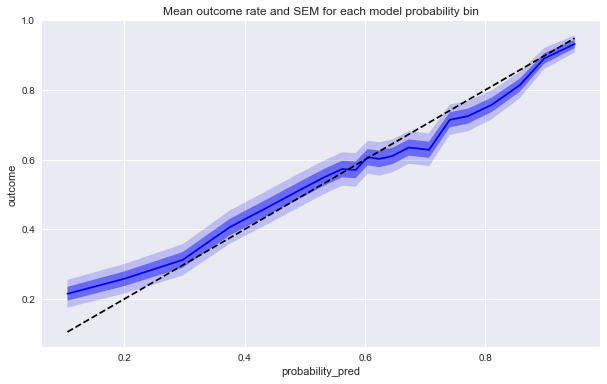

In [41]:
axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title('Mean outcome rate and SEM for each model probability bin')
plt.show()

In [42]:
print('Model accuracy score: {}'.format(accuracy_score(model_df['outcome_pred'], model_df['outcome'])))

Model accuracy score: 0.6711653561788522


___Select the uncalibrated selected features model as our final model.___

In [43]:
model = selected_model

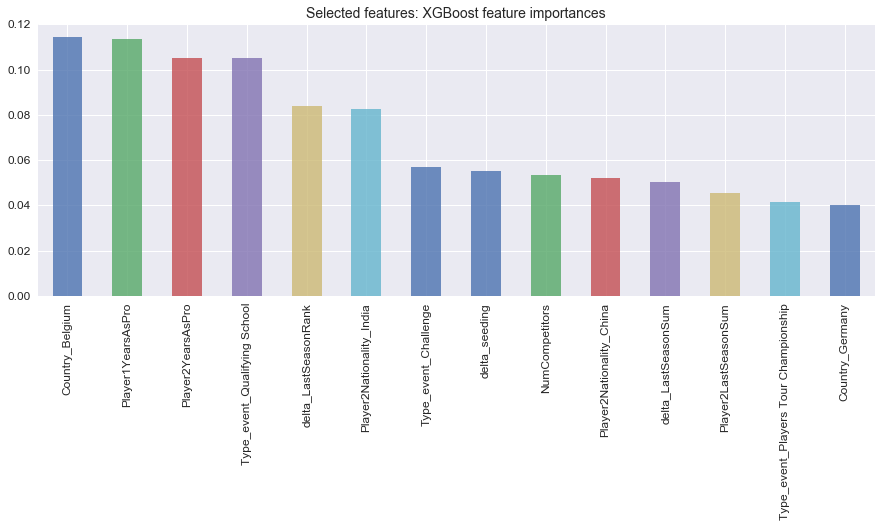

In [44]:
feature_importances = pd.Series(model.feature_importances_, index=SELECTED_FEATURES)
ax = feature_importances.sort_values(ascending=False).plot(
    kind='bar', 
    fontsize=12,
    figsize=(15,5),
    alpha=0.8
)
ax.set_title('Selected features: XGBoost feature importances', fontsize=14)
plt.show()

## How well does our model predict outcomes of particular subsets of matches?

Are there any types of match where the model performs particularly bad? Any that are particularly good?

In [45]:
subset = match_data.loc[
    match_data['TripleCrown'] == 1
]

0.739


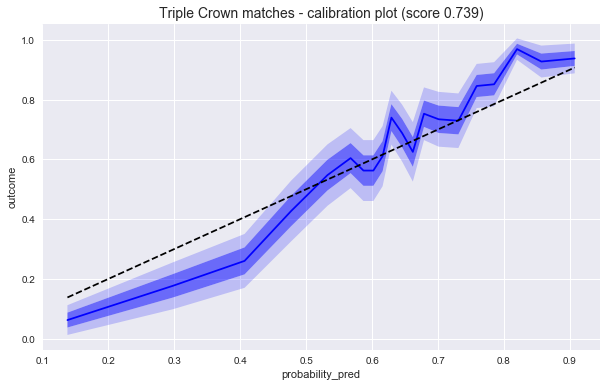

In [46]:
model_df = pd.DataFrame({
    'probability_pred': model.predict_proba(subset[SELECTED_FEATURES])[:, 1], 
    'outcome_pred': model.predict(subset[SELECTED_FEATURES]),
    'outcome': subset[TARGET_COL].values
})

accuracy = round(accuracy_score(model_df['outcome_pred'], model_df['outcome']), 4)
print(accuracy)

axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title(
    'Triple Crown matches - calibration plot (score {})'.format(accuracy), 
    fontsize=14
)
plt.show()

In [47]:
subset = match_data.loc[
    match_data['Country_China'] == 1
]

0.7479


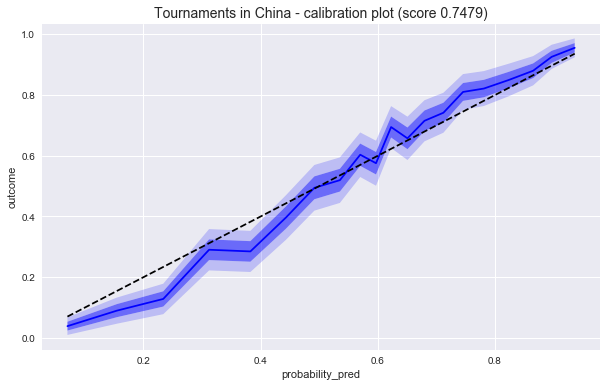

In [48]:
model_df = pd.DataFrame({
    'probability_pred': model.predict_proba(subset[SELECTED_FEATURES])[:, 1], 
    'outcome_pred': model.predict(subset[SELECTED_FEATURES]),
    'outcome': subset[TARGET_COL].values
})

accuracy = round(accuracy_score(model_df['outcome_pred'], model_df['outcome']), 4)
print(accuracy)

axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title(
    'Tournaments in China - calibration plot (score {})'.format(accuracy), 
    fontsize=14
)
plt.show()

In [49]:
subset = match_data.loc[
    match_data['Country_England'] == 1
]

0.7259


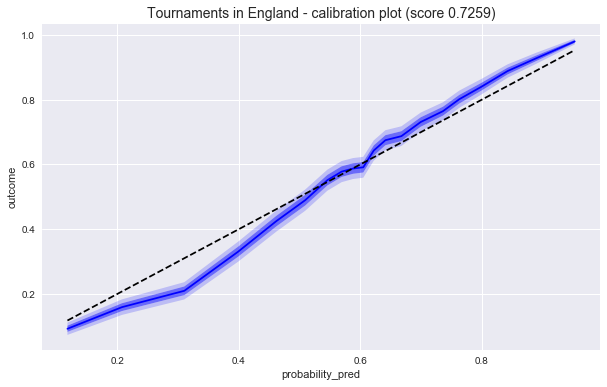

In [50]:
model_df = pd.DataFrame({
    'probability_pred': model.predict_proba(subset[SELECTED_FEATURES])[:, 1], 
    'outcome_pred': model.predict(subset[SELECTED_FEATURES]),
    'outcome': subset[TARGET_COL].values
})

accuracy = round(accuracy_score(model_df['outcome_pred'], model_df['outcome']), 4)
print(accuracy)

axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title(
    'Tournaments in England - calibration plot (score {})'.format(accuracy), 
    fontsize=14
)
plt.show()

Note that when we look at the performance of the `calibrated_xgb` model on these subsets of data, the probabilities are much less in line with actuals. Perhaps if we want to use this, we should calibrate the XGBoost probabilities separately depending on the competition.

0.7371


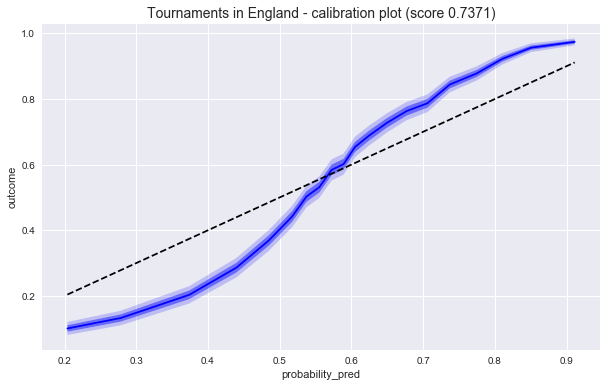

In [51]:
model_df = pd.DataFrame({
    'probability_pred': calibrated_xgb.predict_proba(subset[PROCESSED_FEATURE_LIST])[:, 1], 
    'outcome_pred': calibrated_xgb.predict(subset[PROCESSED_FEATURE_LIST]),
    'outcome': subset[TARGET_COL].values
})

accuracy = round(accuracy_score(model_df['outcome_pred'], model_df['outcome']), 4)
print(accuracy)

axis = calibration_plot(
    model_df['probability_pred'],
    model_df['outcome']
)
axis.set_title(
    'Tournaments in England - calibration plot (score {})'.format(accuracy), 
    fontsize=14
)
plt.show()

### Save model

In [52]:
import pickle
with open('models/selected_model.pickle', 'wb') as f:
    pickle.dump({'features': SELECTED_FEATURES, 'model': model}, f)